# Adversarial Validation

The name of this technique is "Adversarial Validation". it's a clever way to determine if your train and test data comes from the same distribution .

When building a model, we assume the train and test come from the same place. unfortunately, this is not always the case.

🧵🧵🧵


Imagine practicing a dance routine for weeks, but when you get to perform in front of a live audience, it doesn't go smoothly.

This is akin to a model doing well during training but struggling with new data in testing, a problem known as overfitting.


so here's how this technique works👇;

⛔ put your train and test datasets together.

⛔ get rid of the target column.

⛔ create a new binary feature, and set every sample from your train set to 0 and every sample from the test set to 1. this feature will be the new target.


Now, train a simple binary classification model on this new dataset. the goal of this model is to predict whether a sample comes from the train or the test split. the intuition behind this idea is simple.

If all your data comes from the same distribution, this model won't work.


But if the data comes from different distributions, the model will learn to separate it. after you build a model, you can use the ROC-AUC to evaluate it.
if it's close to 0.5, your model can't separate the samples. this means your training and test data come from the same dist.


If the AUC is closer to 1.0, your model learned to differentiate the samples. Your training and test data come from different distributions. If your splits come from different distributions, you won't get anywhere. You can't out-train bad data!


You can also use Adversarial Validation to identify where the problem is coming from:

- Compute the importance of each feature.

- Remove the most important one from the data.

- Rebuild the adversarial model.

- Recompute the ROC-AUC again.



You can repeat this process until the ROC-AUC is close to 0.5 and the model can’t differentiate between training and test samples.

Adversarial Validation is a very useful technique to identify distribution shifts especially in the production environment.

In [122]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # display all columns
import matplotlib.pyplot as plt
import shap
import catboost as cb
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [123]:
import catboost
catboost.__version__

'1.2.2'

In [124]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [125]:
display(train.tail(), test.head())

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
1672,1672,30,Travel_Rarely,945,Sales,1,3,Life Sciences,1,4,Female,73,3,3,Sales Executive,3,Single,8722,14255,1,Y,No,19,3,2,80,0,10,2,4,10,0,0,8,0
1673,1673,32,Travel_Rarely,1303,Research & Development,2,3,Life Sciences,1,1,Male,48,3,1,Research Scientist,2,Married,3544,15972,4,Y,No,19,3,4,80,1,10,3,4,4,2,1,3,0
1674,1674,29,Travel_Frequently,1184,Human Resources,24,3,Human Resources,1,2,Male,36,2,1,Human Resources,1,Married,2804,15322,1,Y,Yes,11,3,3,80,0,1,2,3,1,0,0,0,1
1675,1675,36,Travel_Rarely,441,Sales,9,2,Marketing,1,2,Male,48,4,2,Sales Executive,3,Divorced,5406,4051,1,Y,No,21,4,3,80,2,10,3,2,10,3,0,8,0
1676,1676,36,Travel_Rarely,1141,Research & Development,20,3,Life Sciences,1,3,Female,35,3,1,Laboratory Technician,3,Single,2593,17381,0,Y,No,19,3,4,80,0,10,3,2,8,2,7,3,0


,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1677,19,Non-Travel,992,Research & Development,1,1,Medical,1,4,Male,43,3,1,Laboratory Technician,3,Single,2318,17778,1,Y,No,12,3,4,80,0,1,2,2,1,0,0,0
1,1678,45,Travel_Rarely,1136,Sales,4,4,Marketing,1,3,Male,67,3,2,Sales Executive,1,Divorced,5486,12421,6,Y,Yes,12,3,3,80,1,7,3,3,2,2,2,2
2,1679,37,Travel_Rarely,155,Research & Development,13,3,Life Sciences,1,4,Male,41,3,1,Research Scientist,4,Divorced,2741,23577,4,Y,Yes,13,3,2,80,2,13,2,2,7,7,1,7
3,1680,32,Travel_Rarely,688,Research & Development,1,4,Life Sciences,1,3,Male,89,2,2,Healthcare Representative,3,Single,5228,20364,1,Y,No,13,3,3,80,0,14,2,2,14,10,11,8
4,1681,29,Travel_Frequently,464,Research & Development,9,1,Life Sciences,1,3,Male,79,3,1,Laboratory Technician,4,Single,1223,15178,1,Y,No,14,3,1,80,0,1,5,3,1,0,0,0


In [126]:
train.shape, test.shape

((1677, 35), (1119, 34))

In [127]:
# Remove the target column 'Attrition'
target = 'Attrition'
train_labels = train[target]
train = train.drop(columns=[target])

# Create a new binary feature 'is_test' as the target
train['is_test'] = 0
test['is_test'] = 1

# Combine the datasets
combined_data = pd.concat([train, test], ignore_index=True)
combined_data.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_test
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,42,3,1,Laboratory Technician,4,Married,2596,5099,1,Y,Yes,13,3,2,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,46,3,1,Sales Representative,1,Married,2899,10778,1,Y,No,17,3,4,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,80,3,2,Sales Executive,4,Divorced,4627,16495,0,Y,No,17,3,4,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,40,3,2,Healthcare Representative,1,Married,5347,13384,3,Y,No,14,3,3,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,37,3,5,Manager,1,Single,19033,19805,1,Y,Yes,13,3,3,80,0,31,0,3,31,14,4,10,0


In [128]:
# Split the combined dataset into features and target
X = combined_data.drop(columns=['is_test'])
y = combined_data['is_test']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [129]:
train = cb.Pool(X_train, label=y_train, cat_features=np.where(X_train.dtypes == 'O')[0])
val = cb.Pool(X_val, label=y_val, cat_features=np.where(X_val.dtypes == 'O')[0])

In [130]:
%%time
params = {
    'learning_rate': 0.02,
    'depth': 5,
    'subsample': 0.8,
    'eval_metric': 'AUC',
    'iterations': 2500
}

# Train the CatBoost model
clf = cb.train(pool=train, params=params, num_boost_round=2500, verbose=False)
clf.fit(train, verbose=False)

CPU times: total: 3min 45s
Wall time: 2min 26s


In [133]:
# Make predictions on the validation set
preds = clf.predict(val)

# Evaluate the model using ROC-AUC
roc_auc = roc_auc_score(val.get_label(), preds)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9999951458667056


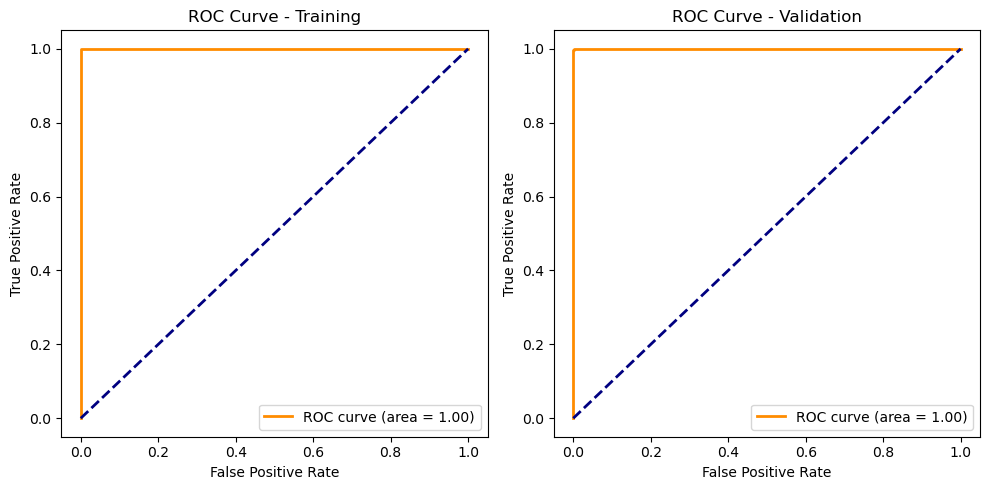

AUC Score (Training): 1.0
AUC Score (Validation): 0.9999951458667056


In [143]:
def calculate_score_on_dataset(X, y, clf, dataset_type):
    pool = cb.Pool(X, label=y, cat_features=np.where(X.dtypes == 'O')[0])
    preds = clf.predict(pool)
    fpr, tpr, _ = metrics.roc_curve(y, preds)
    auc_score = metrics.auc(fpr, tpr)

    return fpr, tpr, auc_score

# Calculate scores and ROC curves for both training and val sets
fpr_train, tpr_train, score_train_cb = calculate_score_on_dataset(X_train, y_train, clf, 'Training')
fpr_test, tpr_test, score_test_cb = calculate_score_on_dataset(X_val, y_val, clf, 'Validation')

# Plot ROC curves in a single row subplot
plt.figure(figsize=(10, 5))

# Plot for Training set
plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(score_train_cb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training')
plt.legend(loc='lower right')

# Plot for val set
plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(score_test_cb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

print("AUC Score (Training):", score_train_cb)
print("AUC Score (Validation):", score_test_cb)

**This is a rather significant AUC. It indicates that there is a significant shift in many of the variables. Let us look at the variables that are the most distinct between the train and test sets.**

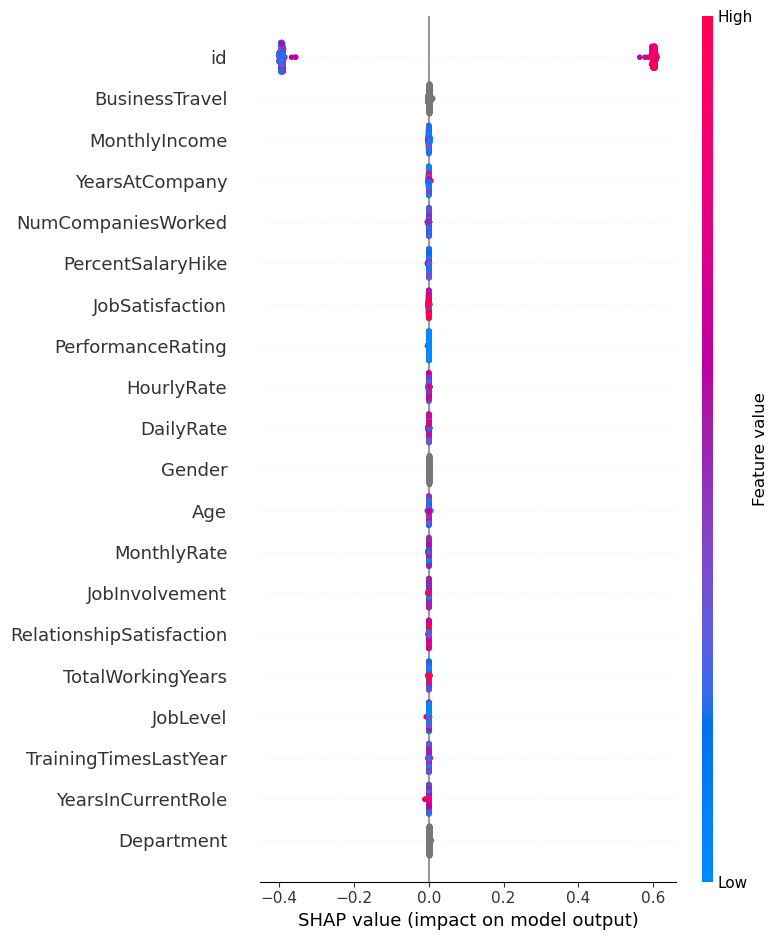

In [174]:
# Create a summary plot using SHAP values
shap_values = clf.get_feature_importance(val, type='ShapValues')
shap.summary_plot(shap_values[:, :-1], pd.DataFrame(X_val, columns=X_val.columns))